In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy import ndimage
from scipy import linalg
from skimage.util.shape import view_as_windows
import random
import math
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from skimage import io

In [2]:
# Read sample data.
img = Image.open('../sample_data/ImageSlice.png')

In [3]:
# Turn image into a Numpy array.
imgArray = np.array(img, dtype=np.uint8)
# Remove alpha channel.
#imgArray = imgArray[:, :, 0]
print(f'IMAGE:\nwidth={imgArray.shape[0]} height={imgArray.shape[1]}')

IMAGE:
width=440 height=596


In [4]:
# Create random window.
window_size = random.randint(50, 150)
x, y = random.randint(0, imgArray.shape[1] - window_size), random.randint(0, imgArray.shape[0] - window_size)
print(f'WINDOW:\nx={x} y={y} width={window_size} height={window_size}')

WINDOW:
x=218 y=48 width=65 height=65


In [5]:
def highlight_rect(x, y, window_size):
    return Rectangle((x, y), window_size, window_size, linewidth=3, edgecolor='r', facecolor='none')

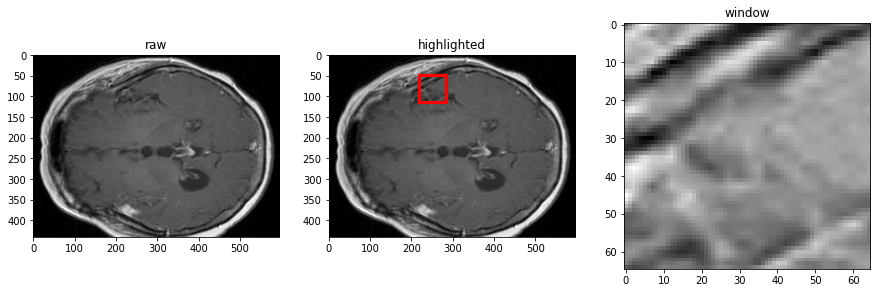

In [6]:
# Show image.
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].set_title('raw')
ax[0].imshow(imgArray, cmap=plt.cm.gray)

# Highlight window within image.
ax[1].set_title('highlighted')
ax[1].imshow(imgArray, cmap=plt.cm.gray)
ax[1].add_patch(highlight_rect(x, y, window_size))

# Crop window.
windowArray = imgArray[y:y + window_size, x:x + window_size]
ax[2].set_title('window')
ax[2].imshow(windowArray, cmap=plt.cm.gray)
plt.show()

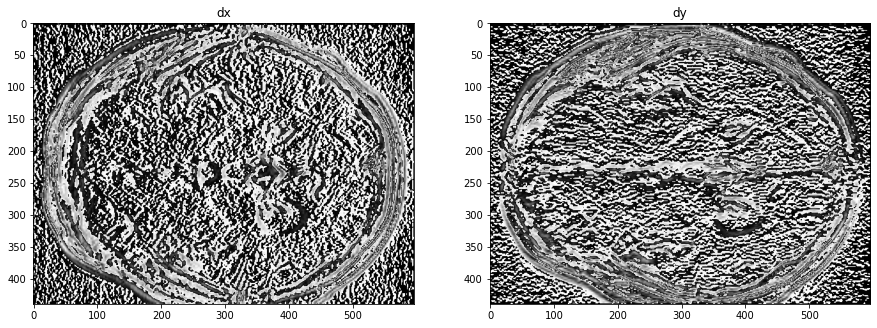

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Define kernel for x differences.
kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

# Define kernel for y differences.
ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Perform x convolution.
dx=ndimage.convolve(imgArray, kx)

# Perform y convolution.
dy=ndimage.convolve(imgArray, ky)

# Display dx & dy.
ax[0].imshow(dx, cmap=plt.cm.gray)
ax[0].set_title('dx')
ax[1].imshow(dy, cmap=plt.cm.gray)
ax[1].set_title('dy')
plt.show()

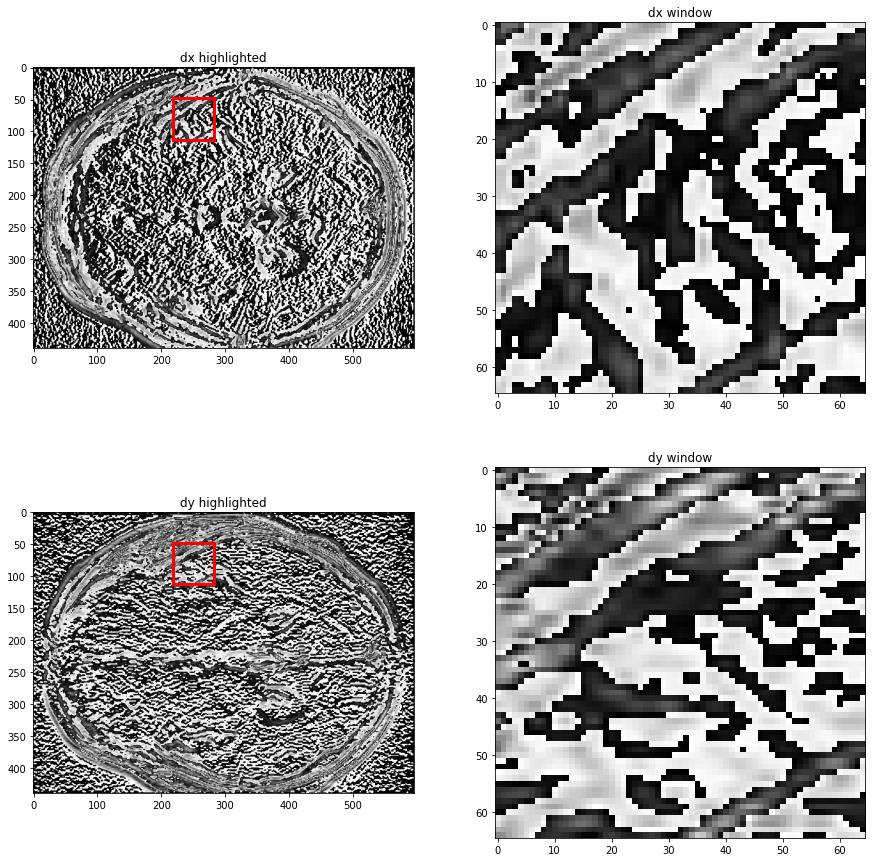

In [8]:
# Create windows.
dx_windows = view_as_windows(dx, (window_size, window_size))
dy_windows = view_as_windows(dy, (window_size, window_size))

# Get window at x,y.
dx_patch = dx_windows[y, x]
dy_patch = dy_windows[y, x]

# Display windows.
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0][0].imshow(dx, cmap=plt.cm.gray)
ax[0][0].add_patch(highlight_rect(x, y, window_size))
ax[0][0].set_title('dx highlighted')
ax[0][1].imshow(dx_patch,cmap=plt.cm.gray)
ax[0][1].set_title('dx window')
ax[1][0].imshow(dy, cmap=plt.cm.gray)
ax[1][0].add_patch(highlight_rect(x, y, window_size))
ax[1][0].set_title('dy highlighted')
ax[1][1].imshow(dy_patch, cmap=plt.cm.gray)
ax[1][1].set_title('dy window')
plt.show()

In [9]:
def svd_dominant_angle(x, y, dx_windows, dy_windows, window_size):
    dx_patch = dx_windows[y, x]
    dy_patch = dy_windows[y, x]
    window_area = window_size * window_size
    flattened_gradients = np.zeros((window_area, 2))
    print(f'Flattened gradients shape = {flattened_gradients.shape}')
    flattened_gradients[:,0] = np.reshape(dx_patch, ((window_area)))
    flattened_gradients[:,1] = np.reshape(dy_patch, ((window_area)))
    print('Calculating svd...', flush=True)
    U, S, V = linalg.svd(flattened_gradients)
    print('Calculating svd done.', flush=True)
    print(f'V (from SVD) = \n{V}')
    dominant_angle = math.atan2(V[0, 0], V[0, 1])
    print(f'Dominant angle = atan2({V[0, 0]}/{V[0, 1]})={dominant_angle}')
    return dominant_angle

Flattened gradients shape = (4225, 2)
Calculating svd...
Calculating svd done.
V (from SVD) = 
[[-0.69640515 -0.71764885]
 [-0.71764885  0.69640515]]
Dominant angle = atan2(-0.6964051464182929/-0.71764885009461)=-2.371216622106527


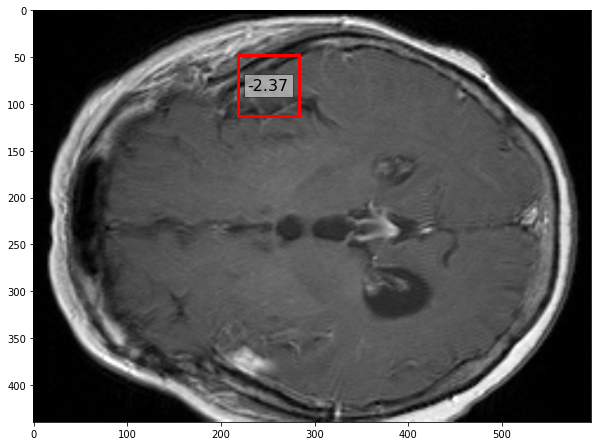

In [10]:
dominant_angle = svd_dominant_angle(x, y, dx_windows, dy_windows, window_size)
# Overlay dominant angle on top of window.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgArray, cmap=plt.cm.gray)
ax.add_patch(highlight_rect(x, y, window_size))
ax.text(x + window_size / 2, y + window_size / 2, round(dominant_angle, 2), fontsize=16, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [11]:
def show_arrow_on_window(windowArray, window_size, dominant_angle):
    fig, ax = plt.subplots(1)
    ax.imshow(windowArray, cmap=plt.cm.gray)
    arrow_dx = math.cos(dominant_angle) * window_size
    arrow_dy = math.sin(dominant_angle) * window_size * -1
    arrow_x = window_size / 2 - math.cos(dominant_angle) * window_size / 2
    arrow_y = window_size / 2 + math.sin(dominant_angle) * window_size / 2
    print(f'x={arrow_x} y={arrow_y} dx={arrow_dx} dy={arrow_dy}')
    arrow = mpatches.Arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, width=30, color='orange')
    ax.add_patch(arrow)
    plt.show()

x=55.823587628074826 y=9.866832741405478 dx=-46.64717525614965 dy=45.266334517189044


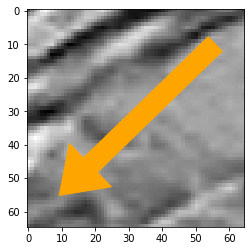

In [12]:
show_arrow_on_window(windowArray, window_size, dominant_angle)